In [97]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import StratifiedKFold

%matplotlib inline
plt.rcParams['figure.figsize'] =  (17.0, 4.0) #Default (6.0, 4.0)

In [98]:
# TODO
# (1) Confidence intervals through bootstraping
# (2) Select at a FPR with enough TPR
# (3) Test our selected model to get a high TPR
# (4) Increase noise in the data to stress the model
# WIN!!!!

In [99]:
# ----------------------------------------------------
# Get data
# ----------------------------------------------------
np.random.seed(15)
X, y = make_classification(n_samples=10000) #80000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # test is only to be used at the very end!

In [100]:
# ----------------------------------------------------
# User defined
# ----------------------------------------------------
FPR_TARGET = 0.05 

In [101]:
# ----------------------------------------------------
# Result objects
# ----------------------------------------------------
roc_results = {} # NAME: [FPR-stats, TPR-stats]
fpr_results = {} # NAME: [matrix of FPR-stats]
thresh_min_results = {} # NAME: thresh_min

In [102]:
def roc_curve_interp(y_test_in, y_pred_in, thresh_standard):
    fpr, tpr, thresh = roc_curve(y_test_in, y_pred_in)
    fpr_interp = np.interp(thresh_standard, thresh, fpr, period=360)
    tpr_interp = np.interp(thresh_standard, thresh, tpr, period=360)
    return fpr_interp, tpr_interp

def add_to_results(fpr, tpr, name, roc_results, fpr_results):
    roc_results[name] = [fpr, tpr]
    if not(name in fpr_results.keys()): fpr_results[name] = fpr
    else: fpr_results[name] = np.vstack([fpr_results[name], fpr])
    return roc_results, fpr_results

In [109]:

# for random classifiers
n_estimator = 10


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y_train, n_folds=5) # ONE IS NOTHING!!

# standard intervals for probability threshold
thresh_standard = np.linspace(1.0, 0.0, 200)


#mean_tpr += interp(mean_fpr, fpr, tpr)

for idx_cv, (idx_train, idx_test) in enumerate(cv):
    y_train_cv = y_train[idx_train]
    X_train_cv = X_train[idx_train]
    y_test_cv  = y_train[idx_test]
    X_test_cv  = X_train[idx_test]
    
    roc_results, fpr_results, _ = classification_models(y_train_cv, X_train_cv, y_test_cv, X_test_cv, 
                                                      roc_results, fpr_results, thresh_standard, True)


In [93]:


# for random classifiers
n_estimator = 10


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y_train, n_folds=5) # ONE IS NOTHING!!

# standard intervals for probability threshold
thresh_standard = np.linspace(1.0, 0.0, 200)


#mean_tpr += interp(mean_fpr, fpr, tpr)

for idx_cv, (idx_train, idx_test) in enumerate(cv):
    y_train_cv = y_train[idx_train]
    X_train_cv = X_train[idx_train]
    y_test_cv  = y_train[idx_test]
    X_test_cv  = X_train[idx_test]

    # It is important to train the ensemble of trees on a different subset
    # of the training data than the linear regression model to avoid
    # overfitting, in particular if the total number of leaves is
    # similar to the number of training samples
    X_train_cv_small, X_train_lr, y_train_cv_small, y_train_lr = train_test_split(X_train_cv,
                                                                                  y_train_cv,
                                                                                  test_size=0.5)

    # Unsupervised transformation based on totally random trees
    rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,random_state=0)

    rt_lm = LogisticRegression()
    pipeline = make_pipeline(rt, rt_lm)
    pipeline.fit(X_train_cv_small, y_train_cv_small)
    y_pred_rt = pipeline.predict_proba(X_test_cv)[:, 1]
    fpr_rt_lm, tpr_rt_lm = roc_curve_interp(y_test_cv, y_pred_rt, thresh_standard)
    roc_results, fpr_results = add_to_results(fpr_rt_lm, tpr_rt_lm, 'RT + LR', roc_results, fpr_results)

    # Supervised transformation based on random forests
    rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
    rf_enc = OneHotEncoder()
    rf_lm = LogisticRegression()
    rf.fit(X_train_cv_small, y_train_cv_small)
    rf_enc.fit(rf.apply(X_train_cv_small))
    rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

    y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test_cv)))[:, 1]
    fpr_rf_lm, tpr_rf_lm = roc_curve_interp(y_test_cv, y_pred_rf_lm, thresh_standard)
    roc_results, fpr_results = add_to_results(fpr_rf_lm, tpr_rf_lm, 'RF + LR', roc_results, fpr_results)


    # Supervised transformation based on gradient boosting
    grd = GradientBoostingClassifier(n_estimators=n_estimator)
    grd_enc = OneHotEncoder()
    grd_lm = LogisticRegression()
    grd.fit(X_train_cv_small, y_train_cv_small)
    grd_enc.fit(grd.apply(X_train_cv_small)[:, :, 0])
    grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

    y_pred_grd_lm = grd_lm.predict_proba(
        grd_enc.transform(grd.apply(X_test_cv)[:, :, 0]))[:, 1]
    fpr_grd_lm, tpr_grd_lm = roc_curve_interp(y_test_cv, y_pred_grd_lm, thresh_standard)
    roc_results, fpr_results = add_to_results(fpr_grd_lm, tpr_grd_lm, 'GBT + LR', roc_results, fpr_results)

    # The gradient boosted model by itself
    y_pred_grd = grd.predict_proba(X_test_cv)[:, 1]
    fpr_grd, tpr_grd = roc_curve_interp(y_test_cv, y_pred_grd, thresh_standard)
    roc_results, fpr_results = add_to_results(fpr_grd, tpr_grd, 'GBT', roc_results, fpr_results)

    # The random forest model by itself
    y_pred_rf = rf.predict_proba(X_test_cv)[:, 1]
    fpr_rf, tpr_rf = roc_curve_interp(y_test_cv, y_pred_rf, thresh_standard)
    roc_results, fpr_results = add_to_results(fpr_rf, tpr_rf, 'RF', roc_results, fpr_results)

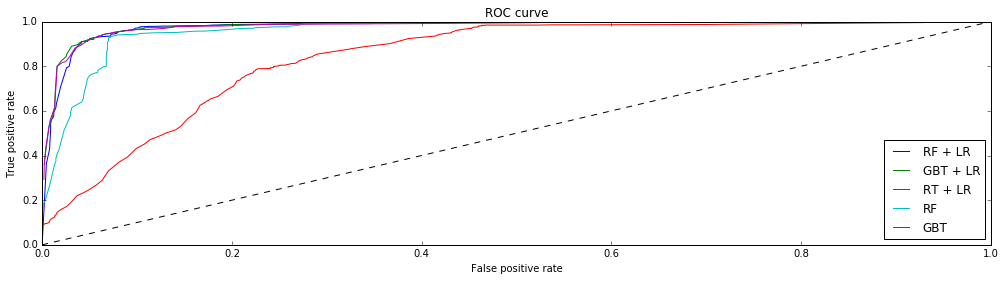

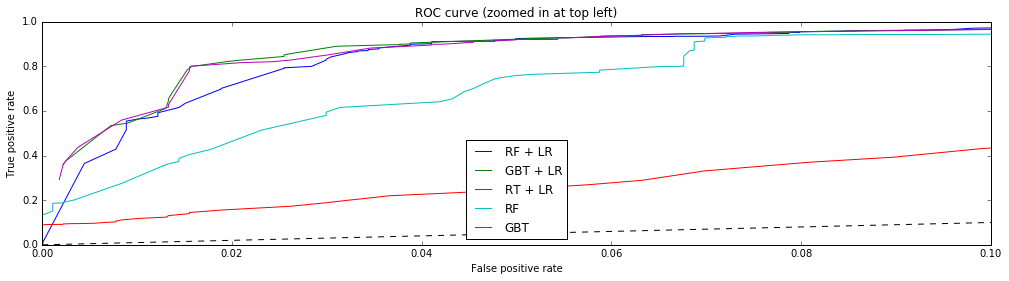

In [110]:
# ----------------------------------------------------
# Plot results
# ----------------------------------------------------

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
for key in roc_results.keys():
    plt.plot(roc_results.get(key)[0], roc_results.get(key)[1], label=key)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


plt.figure(2)
plt.xlim(0, 0.1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
for key in roc_results.keys():
    plt.plot(roc_results.get(key)[0], roc_results.get(key)[1], label=key)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [95]:
# Get the minimum threshold needed for the FPR_TARGET
def get_thresh_min(name, fpr_results, thresh_standard):
    fpr_mean = np.mean(fpr_results.get(name), axis=0)
    fpr_var  = np.std(fpr_results.get(name), axis=0)
    fpr_lb   = fpr_mean + 1.96*fpr_var                     # fpr lower bound CI
    thresh_min = min(thresh_standard[fpr_lb < FPR_TARGET]) # minimum threshold required to achieve FPR_TARGET
    return thresh_min



In [125]:

# Get thresholds for each algorithm
for key in fpr_results.keys():
    thresh_min_results[key] = get_thresh_min(key, fpr_results, thresh_standard)
    
# Train with all training data and predict on testing data
_, _, y_preds = classification_models(y_train, X_train, y_test, X_test, 
                                                      [], [], thresh_standard, False)

# Get prediction accuracy
for key in thresh_min_results.keys():
    print '\n',key
    preds = y_test[y_preds.get(key) > thresh_min_results.get(key)]
    if len(preds) == 0: print 'no predictions :('
    else: print 'Accuracy:', np.mean(preds), 'Number: ', len(preds) 


RF + LR
Accuracy: 0.947162426614 Number:  511

GBT + LR
Accuracy: 0.969262295082 Number:  488

RT + LR
Accuracy: 1.0 Number:  46

RF
Accuracy: 1.0 Number:  53

GBT
Accuracy: 0.965587044534 Number:  494


In [122]:
len(preds)

0

In [107]:
# ----------------------------------------------------
# Test models to predict 1's correctly. 
# Objective is to obtain the FPR_TARGET in the test data.
# We also still want to actually make some predictions.
# ----------------------------------------------------


def classification_models(y_train_cv, X_train_cv, y_test_cv, X_test_cv, 
                          roc_results, fpr_results, thresh_standard, TORECORD):
    
    y_pred_results = {}

    # It is important to train the ensemble of trees on a different subset
    # of the training data than the linear regression model to avoid
    # overfitting, in particular if the total number of leaves is
    # similar to the number of training samples
    X_train_cv_small, X_train_lr, y_train_cv_small, y_train_lr = train_test_split(X_train_cv,
                                                                                  y_train_cv,
                                                                                  test_size=0.5)

    # Unsupervised transformation based on totally random trees
    rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,random_state=0)

    rt_lm = LogisticRegression()
    pipeline = make_pipeline(rt, rt_lm)
    pipeline.fit(X_train_cv_small, y_train_cv_small)
    y_pred_rt = pipeline.predict_proba(X_test_cv)[:, 1]
    y_pred_results['RT + LR'] = y_pred_rt
    if TORECORD:
        fpr_rt_lm, tpr_rt_lm = roc_curve_interp(y_test_cv, y_pred_rt, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_rt_lm, tpr_rt_lm, 'RT + LR', roc_results, fpr_results)

    # Supervised transformation based on random forests
    rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
    rf_enc = OneHotEncoder()
    rf_lm = LogisticRegression()
    rf.fit(X_train_cv_small, y_train_cv_small)
    rf_enc.fit(rf.apply(X_train_cv_small))
    rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

    y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test_cv)))[:, 1]
    y_pred_results['RF + LR'] = y_pred_rf_lm
    if TORECORD:
        fpr_rf_lm, tpr_rf_lm = roc_curve_interp(y_test_cv, y_pred_rf_lm, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_rf_lm, tpr_rf_lm, 'RF + LR', roc_results, fpr_results)


    # Supervised transformation based on gradient boosting
    grd = GradientBoostingClassifier(n_estimators=n_estimator)
    grd_enc = OneHotEncoder()
    grd_lm = LogisticRegression()
    grd.fit(X_train_cv_small, y_train_cv_small)
    grd_enc.fit(grd.apply(X_train_cv_small)[:, :, 0])
    grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

    y_pred_grd_lm = grd_lm.predict_proba(
        grd_enc.transform(grd.apply(X_test_cv)[:, :, 0]))[:, 1]
    y_pred_results['GBT + LR'] = y_pred_grd_lm
    if TORECORD:
        fpr_grd_lm, tpr_grd_lm = roc_curve_interp(y_test_cv, y_pred_grd_lm, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_grd_lm, tpr_grd_lm, 'GBT + LR', roc_results, fpr_results)

    # The gradient boosted model by itself
    y_pred_grd = grd.predict_proba(X_test_cv)[:, 1]
    y_pred_results['GBT'] = y_pred_grd
    if TORECORD:
        fpr_grd, tpr_grd = roc_curve_interp(y_test_cv, y_pred_grd, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_grd, tpr_grd, 'GBT', roc_results, fpr_results)

    # The random forest model by itself
    y_pred_rf = rf.predict_proba(X_test_cv)[:, 1]
    y_pred_results['RF'] = y_pred_rf
    if TORECORD:
        fpr_rf, tpr_rf = roc_curve_interp(y_test_cv, y_pred_rf, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_rf, tpr_rf, 'RF', roc_results, fpr_results)
        
    return roc_results, fpr_results, y_pred_results

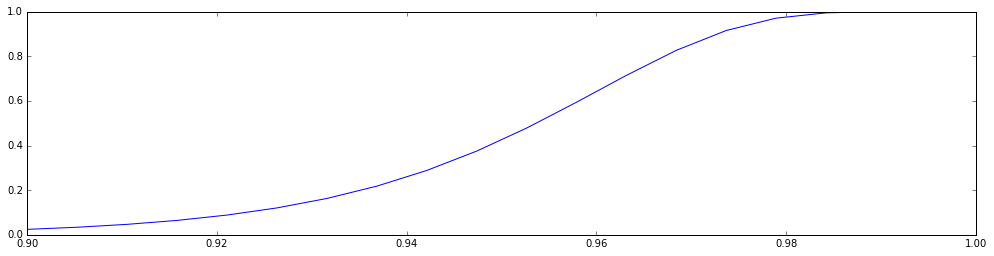

In [70]:
# Basic probability of our success (this is conservative since it assumes we ONLY have 57 games, i.e. we can't restart) 
tpr_system = np.linspace(0.9, 1.0, 20)
accts = 10
games = 57
success = 1 - (1- (tpr_system**games))**accts
plt.plot(tpr_system, success)

In [98]:
fpr_rf_lm, tpr_rf_lm, thresh_rf_lm = roc_curve(y_test, y_pred_rf_lm)

In [83]:
print fpr_rf_lm
print tpr_rf_lm 
print thresh_rf_lm

[ 0.          0.          0.01886792  0.01886792  0.0754717   0.0754717
  0.09433962  0.09433962  0.11320755  0.11320755  0.26415094  0.26415094
  0.47169811  0.47169811  0.54716981  0.54716981  0.8490566   0.8490566   1.
  1.        ]
[ 0.0212766   0.34042553  0.34042553  0.68085106  0.68085106  0.80851064
  0.80851064  0.82978723  0.82978723  0.89361702  0.89361702  0.91489362
  0.91489362  0.93617021  0.93617021  0.95744681  0.95744681  0.9787234
  0.9787234   1.        ]
[ 0.99353372  0.97182527  0.96915644  0.89545654  0.84259307  0.78909184
  0.73894371  0.70526229  0.64536885  0.59701038  0.24732775  0.20517667
  0.12067639  0.11264656  0.08537187  0.07650961  0.02826129  0.02706945
  0.01331803  0.00982246]


In [88]:
print y_pred_rf_lm
print y_test[y_pred_rf_lm>0.99]

[ 0.95793962  0.97999873  0.95215887  0.73894371  0.96536256  0.94794324
  0.03207065  0.12067639  0.13101595  0.99109447  0.98144942  0.99281566
  0.95942505  0.02188886  0.00982246  0.81801677  0.17421499  0.04898457
  0.03440743  0.94446323  0.97612312  0.89545654  0.02889796  0.01708135
  0.9588795   0.02484716  0.132556    0.13603993  0.59701038  0.29338586
  0.02370726  0.0485989   0.53981132  0.79447758  0.02706945  0.98296574
  0.78909184  0.6312506   0.99093979  0.96676055  0.9827294   0.96846292
  0.20517667  0.38651337  0.04730196  0.96798436  0.01878599  0.15639124
  0.26642958  0.82837398  0.94727373  0.06538701  0.01687879  0.08637304
  0.70526229  0.97182527  0.03725583  0.98244663  0.18683545  0.96451504
  0.98248389  0.02826129  0.08586495  0.07650961  0.05162392  0.91990927
  0.97808157  0.08537187  0.99353372  0.11264656  0.0353171   0.12589464
  0.84259307  0.01331803  0.80703146  0.64536885  0.04815943  0.6107493
  0.19586633  0.91979464  0.95853391  0.96915644  0.

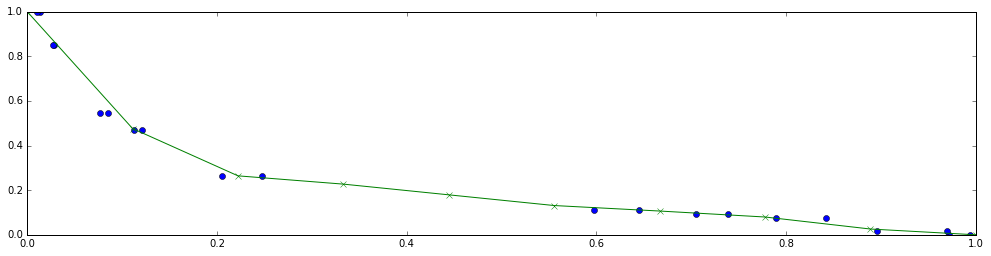

In [114]:

thresh_standard = np.linspace(1.0, 0.0, 10)
fpr_rf_lm_interp = np.interp(thresh_standard,   thresh_rf_lm, fpr_rf_lm, period=360)
import matplotlib.pyplot as plt
plt.plot(thresh_rf_lm, fpr_rf_lm, 'o')

plt.plot(thresh_standard, fpr_rf_lm_interp, '-x')

plt.show()

In [105]:
print thresh_standard
print thresh_rf_lm
print fpr_rf_lm

[ 0.9         0.81111111  0.72222222  0.63333333  0.54444444  0.45555556
  0.36666667  0.27777778  0.18888889  0.1       ]
[ 0.99353372  0.97182527  0.96915644  0.89545654  0.84259307  0.78909184
  0.73894371  0.70526229  0.64536885  0.59701038  0.24732775  0.20517667
  0.12067639  0.11264656  0.08537187  0.07650961  0.02826129  0.02706945
  0.01331803  0.00982246]
[ 0.          0.          0.01886792  0.01886792  0.0754717   0.0754717
  0.09433962  0.09433962  0.11320755  0.11320755  0.26415094  0.26415094
  0.47169811  0.47169811  0.54716981  0.54716981  0.8490566   0.8490566   1.
  1.        ]


In [103]:
print x, y

[ 0.          0.6981317   1.3962634   2.0943951   2.7925268   3.4906585
  4.1887902   4.88692191  5.58505361  6.28318531] [  0.00000000e+00   6.42787610e-01   9.84807753e-01   8.66025404e-01
   3.42020143e-01  -3.42020143e-01  -8.66025404e-01  -9.84807753e-01
  -6.42787610e-01  -2.44929360e-16]


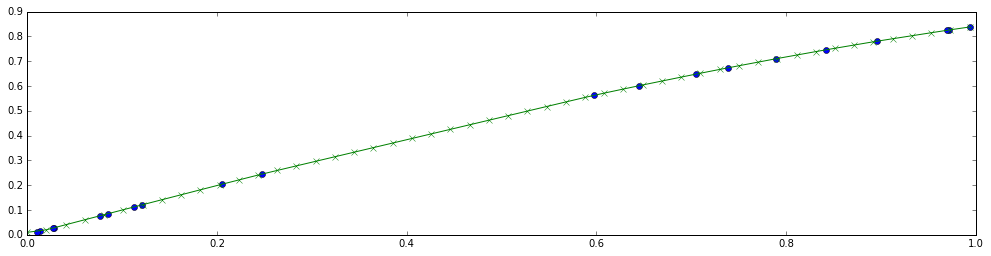

In [111]:
x = thresh_rf_lm # np.linspace(0, 2*np.pi, 10)
y = np.sin(x)
xvals = np.linspace(0, max(x), 50)
yinterp = np.interp(xvals, x, y, period=360)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o')

plt.plot(xvals, yinterp, '-x')

plt.show()

In [27]:
# SAVE FOR LATER






# for random classifiers
n_estimator = 15


thresh_standard = np.linspace(1.0, 0.0, 200)


#mean_tpr += interp(mean_fpr, fpr, tpr)


# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
#fpr_rt_lm, tpr_rt_lm, thresh_rt_lm = roc_curve(y_test, y_pred_rt)
#fpr_rt_lm = np.interp(thresh_standard, thresh_rt_lm, fpr_rt_lm, period=360)
#tpr_rt_lm = np.interp(thresh_standard, thresh_rt_lm, tpr_rt_lm, period=360)
fpr_rt_lm, tpr_rt_lm = roc_curve_interp(y_test, y_pred_rt, thresh_standard)
roc_results['RT + LR'] = [fpr_rt_lm, tpr_rt_lm]


# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
#fpr_rf_lm, tpr_rf_lm, thresh_rf_lm = roc_curve(y_test, y_pred_rf_lm)
fpr_rf_lm, tpr_rf_lm = roc_curve_interp(y_test, y_pred_rf_lm, thresh_standard)
roc_results['RF + LR'] = [fpr_rf_lm, tpr_rf_lm]


# Supervised transformation based on gradient boosting
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
#fpr_grd_lm, tpr_grd_lm, thresh_grd_lm = roc_curve(y_test, y_pred_grd_lm)
fpr_grd_lm, tpr_grd_lm = roc_curve_interp(y_test, y_pred_grd_lm, thresh_standard)
roc_results['GBT + LR'] = [fpr_grd_lm, tpr_grd_lm]


# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
#fpr_grd, tpr_grd, thresh_grd = roc_curve(y_test, y_pred_grd)
fpr_grd, tpr_grd = roc_curve_interp(y_test, y_pred_grd, thresh_standard)
roc_results['GBT'] = [fpr_grd, tpr_grd]


# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
#fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, y_pred_rf)
fpr_rf, tpr_rf = roc_curve_interp(y_test, y_pred_rf, thresh_standard)
roc_results['RF'] = [fpr_rf, tpr_rf]